In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
os.chdir('/home/vco/Projects/pm4py-dcr') # working directory should be pm4py-dcr (the one behind notebooks)
print(os.getcwd())

/home/vco/Projects/pm4py-dcr/notebooks
/home/vco/Projects/pm4py-dcr


In [2]:
import pm4py
import pandas as pd
import numpy as np
from pm4py.objects.dcr import semantics as dcr_semantics
import datetime as dt
from pm4py.algo.discovery.dcr_discover import algorithm as alg

# File names

In [4]:
event_log_file = '/home/vco/Datasets/Sepsis Cases - Event Log.xes'
dcrxml_file = 'models/sepsis_dcr_sp_t.xml'
dcr_title = 'Sepsis Cases'

# Mine with SpT-DisCoveR

In [18]:
event_log = pm4py.read_xes(event_log_file, return_legacy_log_object=True)
sp_dcr = alg.apply(event_log,alg.DCR_SUBPROCESS_TIMED,findAdditionalConditions=True)

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 2107.44it/s]
/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


Is the mined subprocess accepting: True


In [8]:
from copy import deepcopy
from pm4py import get_event_attribute_values

class DiscoverSubprocessTimed:

    def __init__(self):
        self.graph = {
        'events': {},
        'conditionsFor': {},
        'milestonesFor': {},
        'responseTo': {},
        'includesTo': {},
        'excludesTo': {},
        'marking': {'executed': set(),
                    'included':set(),
                    'pending': set()
                    }
        }
        self.logAbstraction = {
            'events': set(),
            'traces': [[]],
            'atMostOnce': set(),
            'chainPrecedenceFor': {},
            'precedenceFor': {},
            'predecessor': {},
            'responseTo': {},
            'successor': {}
        }

    def createLogAbstraction(self, log):
        '''
        Main mining
        :param log: pm4py event log
        :param graph_path: where to save the log
        :return: 0 for success anything else for failure
        '''
        activities = get_event_attribute_values(log, "concept:name")
        events = set(activities)
        self.logAbstraction['events'] = events.copy()
        self.logAbstraction['traces'] = log
        self.logAbstraction['atMostOnce'] = events.copy()
        self.trace_event_positions = pd.DataFrame(columns=list(events),index=range(len(log)),dtype=float).fillna(-1).astype(float)
        for event in events:
            self.logAbstraction['chainPrecedenceFor'][event] = events.copy() - set([event])
            self.logAbstraction['precedenceFor'][event] = events.copy() - set([event])
            self.logAbstraction['predecessor'][event] = set()
            self.logAbstraction['responseTo'][event] = events.copy() - set([event])
            self.logAbstraction['successor'][event] = set()

        for k,trace in enumerate(self.logAbstraction['traces']):
            self.parseTrace(trace,k)

        for i in self.logAbstraction['predecessor']:
            for j in self.logAbstraction['predecessor'][i]:
                self.logAbstraction['successor'][j].add(i)

        return 0

    def parseTrace(self,trace, k = -1):
        '''
        :param trace: array each trace one row and then events in order
        :return: 0 if success anything else for failure
        '''
        localAtLeastOnce = set()
        localSeenOnlyBefore = {}
        lastEvent = ''
        i = 0
        for event_dict in trace:
            event = event_dict['concept:name']
            if k>=0:
                if self.trace_event_positions.at[k,event]<0: # first value
                    self.trace_event_positions.at[k,event] = i
                else:
                    self.trace_event_positions.at[k,event] = np.average([self.trace_event_positions.at[k,event],i]) #unweighted average
            i = i + 1
            # All events seen before this one must be predecessors
            self.logAbstraction['predecessor'][event] = self.logAbstraction['predecessor'][event].union(localAtLeastOnce)
            # If event seen before in trace, remove from atMostOnce
            if event in localAtLeastOnce:
                self.logAbstraction['atMostOnce'].discard(event)
            localAtLeastOnce.add(event)
            # Precedence for (event): All events that occurred before (event) are kept in the precedenceFor set
            self.logAbstraction['precedenceFor'][event] = self.logAbstraction['precedenceFor'][event].intersection(localAtLeastOnce)
            # Chain-Precedence for (event): Some event must occur immediately before (event) in all traces
            if lastEvent != '': #TODO: objects vs strings in sets
                # If first time this clause is encountered - leaves lastEvent in chain-precedence set.
                # The intersect is empty if this clause is encountered again with another lastEvent.
                self.logAbstraction['chainPrecedenceFor'][event] = self.logAbstraction['chainPrecedenceFor'][event].intersection(set([lastEvent]))
            else:
                # First event in a trace, and chainPrecedence is therefore not possible
                self.logAbstraction['chainPrecedenceFor'][event] = set()
            # To later compute responses we note which events were seen before (event) and not after
            if len(self.logAbstraction['responseTo'][event]) > 0:
                # Save all events seen before (event)
                localSeenOnlyBefore[event] = localAtLeastOnce.copy()

            # Clear (event) from all localSeenOnlyBefore, since (event) has now occurred after
            for key in localSeenOnlyBefore:
                localSeenOnlyBefore[key].discard(event)
            lastEvent = event

        for event in localSeenOnlyBefore:
            # Compute set of events in trace that happened after (event)
            seenOnlyAfter = localAtLeastOnce.difference(localSeenOnlyBefore[event])
            # Delete self-relation
            seenOnlyAfter.discard(event)
            # Set of events that always happens after (event)
            self.logAbstraction['responseTo'][event] = self.logAbstraction['responseTo'][event].intersection(seenOnlyAfter)

        return 0

    # Removes redundant relations based on transitive closure
    def optimizeRelation(self,relation):
        '''
        if cond and resp A -> B, B -> C then you can remove an existing relation A -> C
        :param relation:
        :return:
        '''
        for eventA in relation:
            for eventB in relation[eventA]:
                relation[eventA] = relation[eventA].difference(relation[eventB])
        return relation

    def optimizeRelationTransitiveReduction(self,relation):
        #TODO: 1. Adj. List to Adj Matrix, 2. Transive reduction, 3. back to Adj. List
        for eventA in relation:
            for eventB in relation[eventA]:
                print('af')

    def mineFromAbstraction(self,findAdditionalConditions:bool=True):
        '''
        :param findAttitionalConditions:
        :return: a dcr graph
        '''
        # Initialize graph
        # Note that events become an alias, but this is irrelevant since events are never altered
        self.graph['events'] = self.logAbstraction['events'].copy()
        self.graph['marking']['included'] = self.logAbstraction['events'].copy()

        # Initialize all mappings to avoid indexing errors
        for event in self.graph['events']:
            self.graph['conditionsFor'][event] = set()
            self.graph['excludesTo'][event] = set()
            self.graph['includesTo'][event] = set()
            self.graph['responseTo'][event] = set()
            self.graph['milestonesFor'][event] = set()

        # Mine self-exclusions
        for event in self.logAbstraction['atMostOnce']:
            self.graph['excludesTo'][event].add(event)

        # Mine responses from logAbstraction
        self.graph['responseTo'] = deepcopy(self.logAbstraction['responseTo'])
        # Remove redundant responses
        self.graph['responseTo'] = self.optimizeRelation(self.graph['responseTo'])
        # Mine conditions from logAbstraction
        self.graph['conditionsFor'] = deepcopy(self.logAbstraction['precedenceFor'])
        # remove redundant conditions
        self.graph['conditionsFor'] = self.optimizeRelation(self.graph['conditionsFor'])

        # For each chainprecedence(i,j) we add: include(i,j) exclude(j,j)
        for j in self.logAbstraction['chainPrecedenceFor']:
            for i in self.logAbstraction['chainPrecedenceFor'][j]:
                self.graph['includesTo'][i].add(j)
                self.graph['excludesTo'][j].add(j)

        # Additional excludes based on predecessors / successors
        for event in self.logAbstraction['events']:
            # Union of predecessor and successors sets, i.e. all events occuring in the same trace as event
            coExisters = self.logAbstraction['predecessor'][event].union(self.logAbstraction['successor'][event])
            nonCoExisters = self.logAbstraction['events'].difference(coExisters)
            nonCoExisters.discard(event)
            # Note that if events i & j do not co-exist, they should exclude each other.
            # Here we only add i -->% j, but on the iteration for j, j -->% i will be added.
            self.graph['excludesTo'][event] = self.graph['excludesTo'][event].union(nonCoExisters)

            # if s precedes (event) but never succeeds (event) add (event) -->% s if s -->% s does not exist
            precedesButNeverSuceeds = self.logAbstraction['predecessor'][event].difference(self.logAbstraction['successor'][event])
            for s in precedesButNeverSuceeds:
                if not s in self.graph['excludesTo'][s]:
                    self.graph['excludesTo'][event].add(s)

        # Removing redundant excludes.
        # If r always precedes s, and r -->% t, then s -->% t is (mostly) redundant
        for s in self.logAbstraction['precedenceFor']:
            for r in self.logAbstraction['precedenceFor'][s]:
                for t in self.graph['excludesTo'][r]:
                    self.graph['excludesTo'][s].discard(t)

        if findAdditionalConditions:
            # Mining additional conditions:
            # Every event, x, that occurs before some event, y, is a possible candidate for a condition x -->* y
            # This is due to the fact, that in the traces where x does not occur before y, x might be excluded
            possibleConditions = deepcopy(self.logAbstraction['predecessor'])

            # Replay entire log, filtering out any invalid conditions
            for trace in self.logAbstraction['traces']:

                localSeenBefore = set()
                included = self.logAbstraction['events'].copy()
                for event_dict in trace:
                    event = event_dict['concept:name']
                    # Compute conditions that still allow event to be executed
                    excluded = self.logAbstraction['events'].difference(included)
                    validConditions = localSeenBefore.union(excluded)
                    # Only keep valid conditions
                    possibleConditions[event] = possibleConditions[event].intersection(validConditions)
                    # Execute excludes starting from (event)
                    included = included.difference(self.graph['excludesTo'][event])
                    # Execute includes starting from (event)
                    included = included.union(self.graph['includesTo'][event])

            # Now the only possibleCondtitions that remain are valid for all traces
            # These are therefore added to the graph
            for key in self.graph['conditionsFor']:
                self.graph['conditionsFor'][key] = self.graph['conditionsFor'][key].union(possibleConditions[key])

            # Removing redundant conditions
            self.graph['conditionsFor'] = self.optimizeRelation(self.graph['conditionsFor'])

        return 0

    def write_with_lifecycle_subprocesses(self,graph_path,timings):
        data = ''
        withTimings = False
        if timings:
            withTimings = True

        complete_notation = ':Complete'
        subprocesses = {}
        for startEvent in self.graph['excludesTo']:
            for endEvent in self.graph['excludesTo'][startEvent]:
                if startEvent==endEvent:
                    if startEvent not in subprocesses.keys():
                        subprocesses[startEvent] = set()
                    subprocesses[startEvent].add(f'{startEvent}{complete_notation}')

        for event in self.graph['events']:
            data = data + 'EVENT;' + event + '\n'

        for subprocess_name, subprocess_events in subprocesses.items():
            sub_events = '['
            for event in subprocess_events:
                sub_events = sub_events + event + ';'
            sub_events = sub_events[:-1] + ']'
            data = data + 'SUBPROCESS;' +subprocess_name+ sub_events +  '\n'

        for endEvent in self.graph['conditionsFor']:
            for startEvent in self.graph['conditionsFor'][endEvent]:
                if withTimings and (('CONDITION', startEvent,endEvent) in timings.keys()):
                    data = data + 'CONDITION;' + startEvent + ';' + endEvent + ';' + 'DELAY;P' + str(int(timings[('CONDITION',startEvent,endEvent)])) +'D\n'
                else:
                    data = data + 'CONDITION;' + startEvent + ';' + endEvent + '\n'

        for startEvent in self.graph['responseTo']:
            for endEvent in self.graph['responseTo'][startEvent]:
                if withTimings and (('RESPONSE',startEvent,endEvent) in timings.keys()):
                    data = data + 'RESPONSE;' + startEvent + ';' + endEvent + ';' + 'DEADLINE;P' + str(int(timings[('RESPONSE',startEvent,endEvent)])) +'D\n'
                else:
                    data = data + 'RESPONSE;' + startEvent + ';' + endEvent + '\n'

        for startEvent in self.graph['excludesTo']:
            for endEvent in self.graph['excludesTo'][startEvent]:
                if startEvent==endEvent:
                    data = data + f'EXCLUDE;{startEvent}{complete_notation};{endEvent}{complete_notation}\n'
                else:
                    data = data + 'EXCLUDE;'+ startEvent + ';' + endEvent + '\n'

        for startEvent in self.graph['includesTo']:
            for endEvent in self.graph['includesTo'][startEvent]:
                data = data + 'INCLUDE;'+ startEvent + ';' + endEvent + '\n'

        with open(graph_path,'w+') as f:
            f.write(data)


## Optional: create a dummy event log with test traces

In [25]:
dict_keys = ['case:concept:name','concept:name','time:timestamp']

def create_test_traces(ordered_event_matrix):
    start_date = dt.date(2023,1,1)
    case_id = 1
    test_el = []
    for trace in ordered_event_matrix:
        date = start_date
        for event in trace:
            test_el.append({dict_keys[0]:str(case_id),dict_keys[1]:str(event),dict_keys[2]:date})
            date = date + dt.timedelta(days=1) # TODO: there could be a random sample from a distribution here
        case_id = case_id + 1
    df_test = pd.DataFrame(test_el,columns=['case:concept:name','concept:name','time:timestamp'],dtype=str)
    df_test['time:timestamp'] = pd.to_datetime(df_test['time:timestamp'])
    return pm4py.convert_to_event_log(df_test)
A,B,C,D,E,F = 'A','B','C','D','E','F'
event_log = create_test_traces([[A,C,C,B,D],[A,B,C,C,D],[A,E,F,D],[A,F,E,D],[A,B,C,D,A,E,F,D],[A,C,B,C,D,A,F,E,D]])

/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


# Mine DCR graph using the subprocess timed DisCoveR miner

In [13]:
reference_event_log = pm4py.read_xes(event_log_file)
event_log = pm4py.read_xes(event_log_file, return_legacy_log_object=True)
disc_sp_t = DiscoverSubprocessTimed()
disc_sp_t.createLogAbstraction(event_log)
log_abstraction = deepcopy(disc_sp_t.logAbstraction)
events = log_abstraction['events']
for e in events:
    if e in log_abstraction['predecessor'] and e in log_abstraction['predecessor'][e]:
        log_abstraction['predecessor'][e].discard(e)
    if e in log_abstraction['successor'] and e in log_abstraction['successor'][e]:
        log_abstraction['successor'][e].discard(e)

cluster_dict = {}
keys = sorted(log_abstraction['predecessor'].keys())
for k in keys:
    preds_set = frozenset(sorted(log_abstraction["predecessor"][k]))
    if preds_set in cluster_dict.keys():
        cluster_dict[preds_set].add(k)
    else:
        cluster_dict[preds_set] = set([k])

subprocesses = {}
subprocess_notation = 'S'
i = 0
for k,v in cluster_dict.items():
    if len(v)>1:
        subprocesses[f'{subprocess_notation}{i}'] = frozenset(v)
        i = i + 1
# now mine the dcr graph inside the subprocess
subprocess_event_log = deepcopy(event_log)
subprocess_event_log = pm4py.convert_to_dataframe(subprocess_event_log)
subprocess_dcr = {}
for name, subprocess in subprocesses.items():
    subset_log = subprocess_event_log[subprocess_event_log['concept:name'].isin(subprocess)]
    subprocess_dcr[name] = alg.apply(subset_log,alg.DCR_BASIC,findAdditionalConditions=True)
    print(f'Is the mined subprocess accepting: {dcr_semantics.is_accepting(subprocess_dcr[name])}')

# now replay inside the dcr graph and replace with a subprocess
subprocess_log = pm4py.objects.log.obj.EventLog()
trace : pm4py.objects.log.obj.Trace
event : pm4py.objects.log.obj.Event
for trace in event_log:
    #only replace with the subprocess when the subprocess is accepting
    sp_trace = pm4py.objects.log.obj.Trace()
    for event in trace:
        # set all subprocess dcr graphs to their initial state
        sp_dcr_instance = deepcopy(subprocess_dcr)
        sp_event = None
        for name, sp in subprocesses.items():
            if event['concept:name'] in sp:
                # if the event is in the subprocess then execute it within the subprocess model
                executed = dcr_semantics.execute(event['concept:name'], sp_dcr_instance[name]) #TODO: check if it always executes
                accepting = dcr_semantics.is_accepting(sp_dcr_instance[name])
                if accepting:
                    # if the event did execute and is accepting then reset the subprocess to its initial marking
                    sp_dcr_instance[name] = deepcopy(subprocess_dcr[name])
                    # also replace the event with the subprocess in the new event log
                    event['concept:name'] = name
                    sp_event = event
        if not sp_event:
            sp_event = event
        sp_trace.append(sp_event)
    subprocess_log.append(sp_trace)
# now run the dcr graph with the subprocess events replaced as the subprocess
final_dcr = alg.apply(subprocess_log,alg.DCR_BASIC,findAdditionalConditions=True)
final_dcr['subprocesses'] = {}
for name, sp_dcr in subprocess_dcr.items():
    final_dcr['subprocesses'][name] = sp_dcr

parsing log, completed traces :: 100%|██████████| 1050/1050 [00:00<00:00, 2425.04it/s]
/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


Is the mined subprocess accepting: True


In [14]:
final_dcr

{'events': {'Admission IC',
  'Admission NC',
  'CRP',
  'ER Registration',
  'ER Sepsis Triage',
  'ER Triage',
  'IV Antibiotics',
  'IV Liquid',
  'LacticAcid',
  'Leucocytes',
  'Return ER',
  'S0'},
 'conditionsFor': {'Admission IC': {'ER Registration', 'ER Triage'},
  'CRP': set(),
  'LacticAcid': set(),
  'Admission NC': {'ER Registration', 'ER Triage'},
  'Return ER': {'Admission IC', 'Admission NC', 'S0'},
  'ER Triage': set(),
  'IV Liquid': set(),
  'IV Antibiotics': {'ER Sepsis Triage'},
  'S0': {'ER Registration', 'ER Triage'},
  'ER Sepsis Triage': set(),
  'Leucocytes': set(),
  'ER Registration': set()},
 'milestonesFor': {'Admission IC': set(),
  'CRP': set(),
  'LacticAcid': set(),
  'Admission NC': set(),
  'Return ER': set(),
  'ER Triage': set(),
  'IV Liquid': set(),
  'IV Antibiotics': set(),
  'S0': set(),
  'ER Sepsis Triage': set(),
  'Leucocytes': set(),
  'ER Registration': set()},
 'responseTo': {'Admission IC': set(),
  'CRP': set(),
  'LacticAcid': set(),

In [100]:
from pm4py.objects.dcr.exporter import exporter as dcr_exporter

In [105]:
dcr_exporter.apply(dcr_graph=final_dcr,
                   path="models/sepsis_subprocess.xml",
                   variant=dcr_exporter.DCR_XML_SIMPLE,
                   dcr_title='Sepsis Cases subprocess')

In [59]:
reference_dcr = alg.apply(reference_event_log,alg.DCR_BASIC,findAdditionalConditions=True)

/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [60]:
reference_dcr

{'events': {'Admission IC',
  'Admission NC',
  'CRP',
  'ER Registration',
  'ER Sepsis Triage',
  'ER Triage',
  'IV Antibiotics',
  'IV Liquid',
  'LacticAcid',
  'Leucocytes',
  'Release A',
  'Release B',
  'Release C',
  'Release D',
  'Release E',
  'Return ER'},
 'conditionsFor': {'Release D': {'Admission NC',
   'CRP',
   'ER Sepsis Triage',
   'Leucocytes'},
  'Return ER': {'Admission IC',
   'Release A',
   'Release C',
   'Release D',
   'Release E'},
  'Admission IC': {'ER Registration', 'ER Triage'},
  'Leucocytes': set(),
  'ER Triage': set(),
  'LacticAcid': set(),
  'CRP': set(),
  'Admission NC': {'ER Registration', 'ER Triage'},
  'ER Sepsis Triage': set(),
  'Release B': {'CRP',
   'ER Registration',
   'ER Sepsis Triage',
   'ER Triage',
   'Leucocytes'},
  'ER Registration': set(),
  'IV Liquid': set(),
  'Release C': {'Admission NC', 'CRP', 'ER Sepsis Triage', 'Leucocytes'},
  'Release E': {'Admission NC', 'CRP', 'ER Sepsis Triage', 'Leucocytes'},
  'IV Antibioti

In [8]:
disc_sp_t = DiscoverSubprocessTimed()
disc_sp_t.createLogAbstraction(event_log)
log_abstraction = deepcopy(disc_sp_t.logAbstraction)
log_abstraction_with_duplicates = deepcopy(disc_sp_t.logAbstraction)
events = log_abstraction['events']
for e in events:
    if e in log_abstraction['predecessor'] and e in log_abstraction['predecessor'][e]:
        log_abstraction['predecessor'][e].discard(e)
    if e in log_abstraction['successor'] and e in log_abstraction['successor'][e]:
        log_abstraction['successor'][e].discard(e)
log_abstraction.keys()
average_position_in_trace = deepcopy(disc_sp_t.trace_event_positions)

/home/vco/Projects/pm4py-dcr/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [28]:
keys = sorted(log_abstraction['predecessor'].keys())
pred_dict_set = {}
pairwise_set_difference = {}
same_cluster_candidates = {}
cluster_dict = {}
for k in keys:
    predecessors = sorted(log_abstraction["predecessor"][k])
    preds_set = frozenset(predecessors)
    pred_dict_set[k] = preds_set
    if preds_set in cluster_dict.keys():
        cluster_dict[preds_set].add(k)
    else:
        cluster_dict[preds_set] = set([k])
    print(f'{k} :')
    print(f'l: {len(predecessors)} P: {predecessors}')

Admission IC :
l: 9 P: ['Admission NC', 'CRP', 'ER Registration', 'ER Sepsis Triage', 'ER Triage', 'IV Antibiotics', 'IV Liquid', 'LacticAcid', 'Leucocytes']
Admission NC :
l: 10 P: ['Admission IC', 'CRP', 'ER Registration', 'ER Sepsis Triage', 'ER Triage', 'IV Antibiotics', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'Release B']
CRP :
l: 11 P: ['Admission IC', 'Admission NC', 'ER Registration', 'ER Sepsis Triage', 'ER Triage', 'IV Antibiotics', 'IV Liquid', 'LacticAcid', 'Leucocytes', 'Release A', 'Return ER']
ER Registration :
l: 7 P: ['CRP', 'ER Sepsis Triage', 'ER Triage', 'IV Antibiotics', 'IV Liquid', 'LacticAcid', 'Leucocytes']
ER Sepsis Triage :
l: 8 P: ['Admission IC', 'Admission NC', 'CRP', 'ER Registration', 'ER Triage', 'IV Liquid', 'LacticAcid', 'Leucocytes']
ER Triage :
l: 8 P: ['Admission NC', 'CRP', 'ER Registration', 'ER Sepsis Triage', 'IV Antibiotics', 'IV Liquid', 'LacticAcid', 'Leucocytes']
IV Antibiotics :
l: 9 P: ['Admission IC', 'Admission NC', 'CRP', 'ER Registra

NameError: name 'cluster_dict' is not defined

In [100]:
event_matrix = pd.DataFrame(columns=list(events),index=list(events),dtype=int)
event_matrix = event_matrix.fillna(0).astype(int)
predecessor_matrix =  deepcopy(event_matrix)
successor_matrix = deepcopy(event_matrix)
difference_in_predecessors = deepcopy(event_matrix)
for e1 in events:
    for e2 in events:
        if e1 in log_abstraction['predecessor'] and e2 in log_abstraction['predecessor'][e1]:
            predecessor_matrix.at[e1, e2] = 1
        if e1 in log_abstraction['successor'] and e2 in log_abstraction['successor'][e1]:
            successor_matrix.at[e1, e2] = 1
print(predecessor_matrix.equals(successor_matrix.T))

True


In [101]:
predecessor_matrix

,CRP,IV Antibiotics,Release E,Admission IC,Admission NC,Release B,ER Triage,Release C,IV Liquid,ER Sepsis Triage,Return ER,Leucocytes,LacticAcid,ER Registration,Release D,Release A
CRP,0,1,0,1,1,0,1,0,1,1,1,1,1,1,0,1
IV Antibiotics,1,0,0,1,1,0,1,0,1,1,0,1,1,1,0,0
Release E,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,0
Admission IC,1,1,0,0,1,0,1,0,1,1,0,1,1,1,0,0
Admission NC,1,1,0,1,0,1,1,0,1,1,0,1,1,1,0,0
Release B,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,0
ER Triage,1,1,0,0,1,0,0,0,1,1,0,1,1,1,0,0
Release C,1,1,0,1,1,0,1,0,1,1,0,1,1,1,0,0
IV Liquid,1,1,0,1,1,0,1,0,0,1,0,1,1,1,0,0
ER Sepsis Triage,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0,0


In [102]:
dict = predecessor_matrix.sum(axis=1).to_dict()
for k1,v1 in dict.items():
    for k2,v2 in dict.items():
        difference_in_predecessors.at[k1,k2] = np.abs(v1 - v2)
difference_in_predecessors

,CRP,IV Antibiotics,Release E,Admission IC,Admission NC,Release B,ER Triage,Release C,IV Liquid,ER Sepsis Triage,Return ER,Leucocytes,LacticAcid,ER Registration,Release D,Release A
CRP,0,2,1,2,1,1,3,1,2,3,3,0,0,4,1,1
IV Antibiotics,2,0,1,0,1,1,1,1,0,1,5,2,2,2,1,1
Release E,1,1,0,1,0,0,2,0,1,2,4,1,1,3,0,0
Admission IC,2,0,1,0,1,1,1,1,0,1,5,2,2,2,1,1
Admission NC,1,1,0,1,0,0,2,0,1,2,4,1,1,3,0,0
Release B,1,1,0,1,0,0,2,0,1,2,4,1,1,3,0,0
ER Triage,3,1,2,1,2,2,0,2,1,0,6,3,3,1,2,2
Release C,1,1,0,1,0,0,2,0,1,2,4,1,1,3,0,0
IV Liquid,2,0,1,0,1,1,1,1,0,1,5,2,2,2,1,1
ER Sepsis Triage,3,1,2,1,2,2,0,2,1,0,6,3,3,1,2,2


In [103]:
subprocess_candidates = set()
for e1 in events:
    for e2 in events:
        if e1!=e2 and difference_in_predecessors.at[e1,e2]==0 and difference_in_predecessors.at[e2,e1]==0:
            subprocess_candidates.add(e1)
            subprocess_candidates.add(e2)
len(subprocess_candidates)

14

In [104]:
subprocess_candidates

{'Admission IC',
 'Admission NC',
 'CRP',
 'ER Sepsis Triage',
 'ER Triage',
 'IV Antibiotics',
 'IV Liquid',
 'LacticAcid',
 'Leucocytes',
 'Release A',
 'Release B',
 'Release C',
 'Release D',
 'Release E'}

## Test if an assumption on ordering can be made

You need in the log abstraction a matrix that is with the following dimensions:
no. of traces X no. of events.
To construct the matrix:
For each trace:
    Record the position of the event in the trace (the traces must be ordered by timestamp)
For each column (an event):
    Do a mean/mode/statistical test of the event column and compare all candidate subprocess events with each other
The assumption is that if the candidate subprocess events have averages close to each other than they are grouped together.
Check what is the natural probability distribution for averages.


In [105]:
average_position_in_trace

,CRP,IV Antibiotics,Release E,Admission IC,Admission NC,Release B,ER Triage,Release C,IV Liquid,ER Sepsis Triage,Return ER,Leucocytes,LacticAcid,ER Registration,Release D,Release A
0,17.296875,7.0,-1.0,-1.0,8.0,-1.0,4.0,-1.0,6.0,5.0,-1.0,17.578125,3.00000,0.0,-1.0,21.0
1,7.750000,7.0,-1.0,-1.0,8.0,-1.0,1.0,-1.0,6.0,5.0,-1.0,4.000000,3.00000,0.0,-1.0,11.0
2,9.500000,6.0,-1.0,-1.0,7.5,-1.0,1.0,-1.0,5.0,2.0,-1.0,8.500000,-1.00000,0.0,-1.0,13.0
3,6.500000,7.0,-1.0,-1.0,8.0,-1.0,1.0,-1.0,6.0,2.0,12.0,7.000000,4.00000,0.0,-1.0,11.0
4,4.000000,7.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,3.0,2.0,-1.0,5.000000,6.00000,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,26.140625,6.0,-1.0,7.0,22.0,-1.0,1.0,-1.0,-1.0,2.0,-1.0,23.687500,17.03125,0.0,-1.0,29.0
1046,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,2.0,-1.0,-1.000000,-1.00000,0.0,-1.0,-1.0
1047,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,2.0,-1.0,-1.000000,-1.00000,0.0,-1.0,-1.0
1048,10.000000,7.0,-1.0,-1.0,8.0,-1.0,1.0,-1.0,6.0,2.0,-1.0,9.250000,7.50000,0.0,-1.0,14.0


In [106]:
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

In [107]:
def freedman_diaconis_rule(data):
    """rule to find the bin width and number of bins from data"""
    if (stats.iqr(data)>0):
        bin_width = 2*stats.iqr(data) / len(data)**(1/3)
        Nbins = int(np.ceil((data.max()-data.min())/bin_width))
        return Nbins, bin_width
    else:
        return 100, 0

def gaussian(x, mu, sigma):
    return 1./(np.sqrt(2*np.pi)*sigma)*np.exp(-0.5 * (1./sigma*(x - mu))**2)

In [135]:
average_position_in_trace.replace(-1,None).T

,0,1,2,3,4,5,6,7,8,9,...,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049
CRP,17.296875,7.75,9.5,6.5,4.0,4.0,8.0,7.75,7.0,6.0,...,11.875,4.0,3.0,3.0,17.0625,26.140625,None,None,10.0,None
IV Antibiotics,7.0,7.0,6.0,7.0,7.0,6.0,4.0,None,3.0,7.0,...,None,7.0,None,6.0,7.0,6.0,None,None,7.0,None
Release E,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
Admission IC,None,None,None,None,None,None,None,6.0,None,None,...,None,None,None,None,11.5,7.0,None,None,None,None
Admission NC,8.0,8.0,7.5,8.0,None,8.0,8.0,9.0,7.0,8.0,...,5.0,None,None,7.0,23.0,22.0,None,None,8.0,None
Release B,None,None,None,None,None,None,None,12.0,None,None,...,None,None,None,None,None,None,None,None,None,None
ER Triage,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Release C,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
IV Liquid,6.0,6.0,5.0,6.0,3.0,7.0,3.0,None,None,6.0,...,None,6.0,None,8.0,3.0,None,None,None,6.0,None
ER Sepsis Triage,5.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [165]:
std_event_position

ER Registration      0.395146
ER Triage            0.733107
ER Sepsis Triage     1.168722
IV Antibiotics       1.265161
IV Liquid            1.917539
Admission NC         6.424737
Admission IC         7.037852
LacticAcid           9.122668
Release A            9.550416
CRP                 11.040051
Leucocytes          11.217146
Release E           11.391517
Return ER           12.061935
Release D           16.492203
Release B           16.704994
Release C           33.899361
dtype: float64

In [164]:
mean_event_position

ER Registration      0.082857
ER Triage            1.231905
ER Sepsis Triage     2.527169
IV Liquid            5.108898
IV Antibiotics       6.379101
LacticAcid           6.565737
Admission NC         9.622109
Leucocytes           9.720127
CRP                  9.926179
Admission IC        10.027273
Release A           15.001490
Return ER           17.326531
Release B           18.125000
Release E           22.166667
Release C           22.800000
Release D           22.916667
dtype: float64

In [167]:
average_position_in_trace.replace(-1,None).median().sort_values()

ER Registration      0.000
ER Triage            1.000
ER Sepsis Triage     2.000
LacticAcid           5.000
IV Liquid            6.000
IV Antibiotics       7.000
Leucocytes           7.375
CRP                  8.000
Admission IC         8.000
Admission NC         8.000
Release A           13.000
Release B           14.000
Release C           14.000
Return ER           15.000
Release D           18.000
Release E           20.000
dtype: float64

In [163]:
event_mode = average_position_in_trace.replace(-1,None).mode()
event_mode[event_mode.index==0].sort_values(by=0,axis=1).T.to_dict()[0]

{'ER Registration': 0.0,
 'ER Triage': 1.0,
 'ER Sepsis Triage': 2.0,
 'Leucocytes': 3.0,
 'CRP': 4.0,
 'LacticAcid': 5.0,
 'IV Liquid': 6.0,
 'IV Antibiotics': 7.0,
 'Admission IC': 8.0,
 'Admission NC': 8.0,
 'Release E': 10.0,
 'Release B': 11.0,
 'Release A': 11.0,
 'Return ER': 12.0,
 'Release D': 12.0,
 'Release C': 13.0}

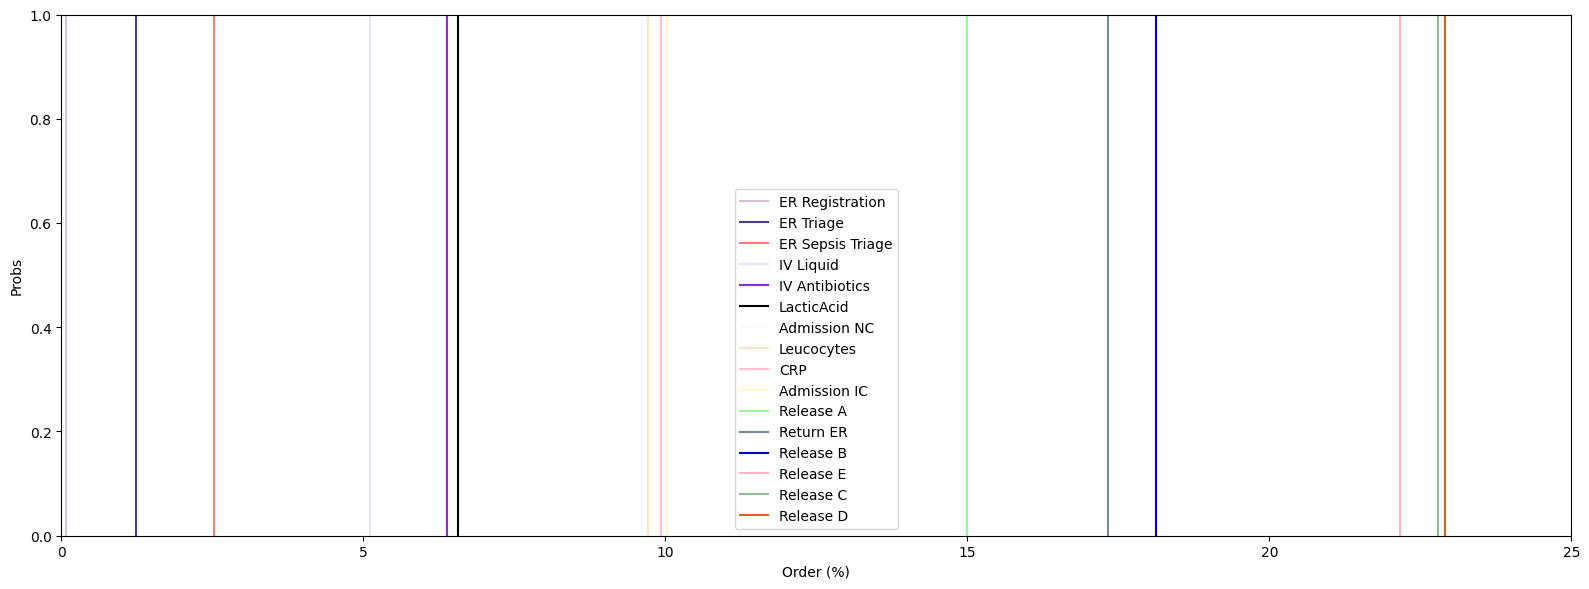

In [125]:
mean_event_position = average_position_in_trace.replace(-1,None).mean().sort_values()
order = mean_event_position.index.values
std_event_position = average_position_in_trace.replace(-1,None).std().sort_values()
Nbins, binWidth = freedman_diaconis_rule(mean_event_position)

keys = list(mcolors.CSS4_COLORS.keys())
random.shuffle(keys)

fig, ax = plt.subplots(figsize=(16,6))
i = 0
for event in mean_event_position.index:
    mu = mean_event_position[event]
    sigma = std_event_position[event]
    color = mcolors.CSS4_COLORS[keys[i]]
    i = i + 1
    # ax.plot(gaussian(np.linspace(0, 20, 100, ), mu, sigma),label=f'{event}: μ={mu:.2f}, σ={sigma:.2f}',c=color)
    ax.axvline(mu,c=color,label = event)
    ax.set_xlim(0,25)
    ax.set_ylim(0,1)
    ax.set_xlabel('Order (%)')
    ax.set_ylabel('Probs')
    ax.set_title('')
    ax.legend()
plt.tight_layout()
plt.show()

## Test if a mask where a pair of events marked with 1 are not candidates for a subprocess and 0 are candidates can then define a border around groups of events

In [126]:
order

array(['ER Registration', 'ER Triage', 'ER Sepsis Triage', 'IV Liquid',
       'IV Antibiotics', 'LacticAcid', 'Admission NC', 'Leucocytes',
       'CRP', 'Admission IC', 'Release A', 'Return ER', 'Release B',
       'Release E', 'Release C', 'Release D'], dtype=object)

## Test if a ML based clustering method might work
It can take the text as a vector embedding to make the clusters
IT can take some process model related embedding

In [28]:
data = [
[100, 10, 1],
[200, 20, 2],
[300, 30, 3]]

df = pd.DataFrame(data)

df.sum(axis=1)

0    111
1    222
2    333
dtype: int64